In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pylab as plt
plt.style.use('seaborn-white')

from astropy.io import ascii
from pyts.bow import BOW
from pyts.approximation import PAA
from pyts.classification import SAXVSMClassifier
from pyts.quantization import SAX
from pyts.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'pyts.bow'

In [2]:
class LightCurve():
    def __init__(self,filename,info):
        self.filename = filename
        self.info = info
        self.lightcurve=None
        self.lc_table = None
        
    def _load_ogle(self):
        names = ["HJD","mag","error"]
        data = ascii.read(self.filename, data_start=2, delimiter=' ', format='csv', names=names)
        return data
    
    def _load_ogle2(self):
        names = ["HJD","mag","error","points","flag"]
        data = ascii.read(self.filename, data_start=2, delimiter=' ', format='csv', names=names)
        data["HJD"]=data["HJD"]-2400000.0
        return data
    
    def _load_ogle_nami(self):
        names = ["HJD","mag","error","points","number","flag","logical","mag_nami"]
        data = ascii.read(self.filename, data_start=1, delimiter=' ',names = names)
        data["HJD"]=data["HJD"]-2400000.0
        return data
    
    def _remove_outliers(data):
        raw_number_outliers,raw_outliers = pyasl.generalizedESD(data["mag"],4,0.15)

        mask = np.zeros(np.size(data["mag"]))
        mask[raw_outliers] = 1

        ma_array = ma.array(data["mag"], mask = mask)
        masked_data = data[~ma_array.mask,:]
        return masked_data
    
    def loader(self):
        if self.info["Survey"]=="OGLE":
            data = self._load_ogle()
        if self.info["Survey"]=="OGLEII":
            data = self._load_ogle2()
        if self.info["Survey"]=="OGLENAMI":
            data = self._load_ogle_nami()
        self.lc_table = data.to_pandas()
        return data
    
    def envelope(self):
        params={"span": 0.2, "npoints": 400}
        self.envelope_table = env.envelope(self.lc_table,params=params)
        return 
    
    

In [3]:
import envelope as env

name = './lmc_sc10_i_199435.dat'
info = {"Survey": 'OGLENAMI'}
lightcurve = LightCurve(name,info)
lightcurve.loader()
lightcurve.envelope()

In [4]:
print lightcurve.envelope_table

              HJD        mag
0    50459.700670  16.367694
1    50463.242165  16.368123
2    50466.783661  16.368536
3    50470.325156  16.368929
4    50473.866651  16.369298
5    50477.408147  16.369656
6    50480.949642  16.370003
7    50484.491138  16.370338
8    50488.032633  16.370660
9    50491.574128  16.370968
10   50495.115624  16.371259
11   50498.657119  16.371533
12   50502.198614  16.371794
13   50505.740110  16.372043
14   50509.281605  16.372284
15   50512.823100  16.372518
16   50516.364596  16.372738
17   50519.906091  16.372935
18   50523.447587  16.373111
19   50526.989082  16.373267
20   50530.530577  16.373405
21   50534.072073  16.373526
22   50537.613568  16.373632
23   50541.155063  16.373724
24   50544.696559  16.373803
25   50548.238054  16.373871
26   50551.779549  16.373930
27   50555.321045  16.373979
28   50558.862540  16.374022
29   50562.404036  16.374060
..            ...        ...
370  51770.053954  16.339978
371  51773.595450  16.341068
372  51777.136

In [5]:
import os
import ipywidgets as widgets
from sqlalchemy import *
from IPython.display import display

In [6]:
from sklearn import preprocessing
import FATS

f = widgets.FloatProgress(min=0, max=2446,description='Analysis')
display(f)

engine = create_engine('sqlite:///BeStarsCatalog.db')
metadata = MetaData()
metadata.reflect(bind=engine)
zebrun = metadata.tables['Zebrun']

conn = engine.connect()
selection = select([zebrun])
result = conn.execute(selection).fetchall()

id = 0
lightcurve = LightCurve()
a = FATS.FeatureSpace(featureList=['Skew' ])
error_count = 0

skewness = []

for counter,row in enumerate(result):
        id += 1
        zebrunname = str(row['OGLE'])
        filename =  'OGLE'+zebrunname+'.dat'
        name = './ZebrunSource/LMC/'+filename
        info = {"Filename": name, "Survey": 'OGLE'}
        
        try:
            lightcurve.loader(info)
            lightcurve.envelope()
            lc = lightcurve.lc_table
            a.calculateFeature(np.array([lightcurve.envelope_table["mag"],lightcurve.envelope_table["HJD"]]))
            skewness = a.result()
        except:
            error_count +=1
            print('%s missing light curve - %d' % (filename,counter))

        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        plt.title(filename)
        plt.xlabel('mag')
        plt.ylabel('HJD')
        skew_label = "Sk: %.3f" % float(skewness[0])
        plt.text(0.1, 0.8,skew_label, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
        plt.plot(lc["HJD"],lc["mag"],'b.')
        plt.plot(lightcurve.envelope_table["HJD"],lightcurve.envelope_table["mag"],'r-')
        figname = './ZebrunSource/LMC/'+filename.replace('dat','png')
        
        plt.savefig(figname,format="png")
        f.value=counter
        print("%s %.3f %d" % (filename,float(skewness),counter))

FloatProgress(value=0.0, description=u'Analysis', max=2446.0)

TypeError: __init__() takes exactly 3 arguments (1 given)

Test of three light curves with different profiles. Comparison of skewness values *Sk*
(symmetry/asymmetry of light curve points distribution). With the help of python library [*FATS*](http://isadoranun.github.io/tsfeat/FeaturesDocumentation.html) it is very easy. Envelope of light curve is unnormalized, but *FATS* library automatically normalize data.

In [7]:
import scipy.stats as st
from sklearn import preprocessing
import FATS
a = FATS.FeatureSpace(featureList=['Skew' ])

name = './ZebrunSource/LMC/'
examples = ['OGLE05070900-7001007.dat','OGLE05072801-6823515.dat','OGLE05013451-6907575.dat']
info = {"Survey": 'OGLE'}

skewness_envelopes = []
curtosis_envelopes = []
params={"span": 0.2, "npoints": 400}

examples_lcs = []
width_correction = 0.9

envelope_histogram={}
envelope_histogram["x"]=[]
envelope_histogram["y"]=[]

width = []

for example in examples:
    filename = name+example
    buffer_lc = LightCurve(filename,info)
    lc = buffer_lc.loader().to_pandas()
    buffer_lc.envelope()
    examples_lcs.append(buffer_lc.envelope_table)
    curtosis_envelopes.append(st.kurtosis(np.array(buffer_lc.envelope_table["mag"])))
    a.calculateFeature(np.array([buffer_lc.envelope_table["mag"],buffer_lc.envelope_table["HJD"]]))
    skewness = a.result()
    
    histogram = np.histogram(buffer_lc.envelope_table["mag"],bins=12)
    histogram_norm  = preprocessing.scale(histogram[0])
    histogram_x = histogram[1]
    centers = (histogram_x[1:]+histogram_x[:-1])*0.5
    
    envelope_histogram["y"].append(histogram_norm)
    envelope_histogram["x"].append(centers)
    
    bin_size = (centers[0]-centers[1])
    width.append(bin_size*width_correction)
    
    skewness_envelopes.append(skewness)


/home/viktor/Envs/besax/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/viktor/Envs/besax/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/viktor/Envs/besax/local/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Visualization of selected light curves with different profiles and skewness values. It is clear, that skewness value does not contain direct information about profile of the light curve and thus light curves with the close skewness values does not not mean similiraity their profiles necessarily.

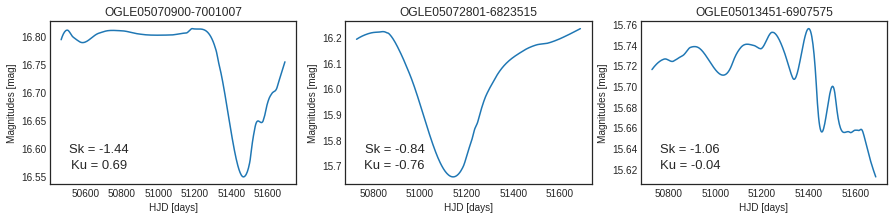

In [9]:
fig, ax = plt.subplots(1, 3,figsize=(15,3))

#LMC SC12 163324 - OGLE05070900-7001007
ax[0].set_title('OGLE05070900-7001007')
ax[0].set_xlabel('HJD [days]')
ax[0].set_ylabel('Magnitudes [mag]')

Sk = 'Sk = %.2f' % (skewness_envelopes[0])
Ku = 'Ku = %.2f' % (curtosis_envelopes[0])

ax[0].text(0.2,0.2,Sk,transform=ax[0].transAxes,
           fontsize=13, ha='center')
ax[0].text(0.2,0.1,Ku,transform=ax[0].transAxes,
           fontsize=13, ha='center')

ax[0].plot(examples_lcs[0]["HJD"],examples_lcs[0]["mag"])

#LMC SC13 264415 - OGLE05072801-6823515
ax[1].set_title('OGLE05072801-6823515')
ax[1].set_xlabel('HJD [days]')
ax[1].set_ylabel('Magnitudes [mag]')

Sk = 'Sk = %.2f' % (skewness_envelopes[1])
Ku = 'Ku = %.2f' % (curtosis_envelopes[1])

ax[1].text(1.4,0.2,Sk,transform=ax[0].transAxes,
           fontsize=13, ha='center')
ax[1].text(1.4,0.1,Ku,transform=ax[0].transAxes,
           fontsize=13, ha='center')
ax[1].plot(examples_lcs[1]["HJD"],examples_lcs[1]["mag"])

#LMC SC15 137470 - OGLE05013451-6907575
ax[2].set_title('OGLE05013451-6907575')
ax[2].set_xlabel('HJD [days]')
ax[2].set_ylabel('Magnitudes [mag]')

Sk = 'Sk = %.2f' % (skewness_envelopes[2])
Ku = 'Ku = %.2f' % (curtosis_envelopes[2])
ax[2].text(2.6,0.2,Sk,transform=ax[0].transAxes,
           fontsize=13, ha='center')
ax[2].text(2.6,0.1,Ku,transform=ax[0].transAxes,
           fontsize=13, ha='center')

ax[2].plot(examples_lcs[2]["HJD"],examples_lcs[2]["mag"])
plt.savefig("A1envelope.pdf")

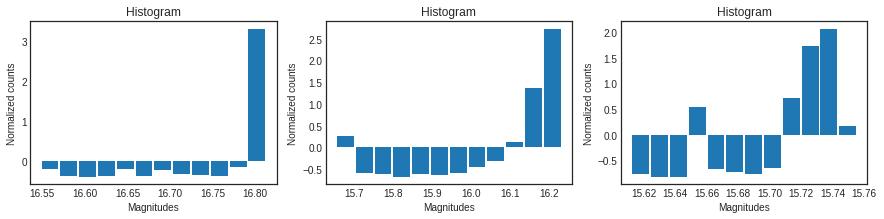

In [27]:
fig, ax = plt.subplots(1, 3,figsize=(15,3))


ax[0].set_title('Histogram')
ax[0].set_xlabel('Magnitudes')
ax[0].set_ylabel('Normalized counts')
ax[0].bar(envelope_histogram["x"][0],envelope_histogram["y"][0],width[0],align='center')

ax[1].set_title('Histogram')
ax[1].set_xlabel('Magnitudes')
ax[1].set_ylabel('Normalized counts')
ax[1].bar(envelope_histogram["x"][1],envelope_histogram["y"][1],width[1],align='center')

ax[2].set_title('Histogram')
ax[2].set_xlabel('Magnitudes')
ax[2].set_ylabel('Normalized counts')
ax[2].bar(envelope_histogram["x"][2],envelope_histogram["y"][2],width[2],align='center')

plt.savefig("A1histograms.pdf")